In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("traffic_weather_merged.csv")




In [10]:
df.head(10)


,traffic_id,city,area,vehicle_count,avg_speed_kmh,accident_count,congestion_level,road_condition,visibility_m_traffic,weather_id,...,visibility_m_weather,weather_condition,air_pressure_hpa,year,month,day,hour,day_of_week,is_weekend,is_rush_hour
0,11317.0,London,Hammersmith,182.0,46.1,0.0,Unknown,Snowy,6210.0,5001,...,6493.0,Storm,989.095139,2024,8,22,1,Thursday,False,0
1,11317.0,London,Hammersmith,182.0,46.1,0.0,Unknown,Snowy,6210.0,7283,...,3709.0,Clear,1017.684702,2024,8,22,1,Thursday,False,0
2,9860.0,London,Hackney,218.0,46.1,0.0,Unknown,Damaged,5034.0,8222,...,5081.0,Fog,1042.611040,2024,8,24,21,Saturday,True,0
3,13804.0,London,Kensington,197.0,51.4,0.0,Low,Dry,5081.0,6033,...,4282.0,Fog,1012.702063,2024,12,2,13,Monday,False,0
4,13804.0,London,Kensington,197.0,51.4,0.0,Low,Dry,5081.0,8420,...,3688.0,Snow,1028.691704,2024,12,2,13,Monday,False,0
5,9799.0,London,Chelsea,185.0,41.4,0.0,Low,Damaged,8907.0,7561,...,2478.0,Rain,1022.397876,2024,9,18,22,Wednesday,False,0
6,9486.0,London,Hammersmith,201.0,51.6,0.0,Unknown,Damaged,9025.0,5358,...,50.0,Rain,1014.936350,2024,6,19,8,Wednesday,False,1
7,13909.0,London,Hackney,178.0,48.6,0.0,Unknown,Damaged,3828.0,5080,...,1442.0,Rain,1008.727733,2024,3,28,19,Thursday,False,1
8,10294.0,London,Camden,201.0,35.4,0.0,Unknown,Dry,191.0,6668,...,3491.0,Clear,1021.312611,2024,1,3,19,Wednesday,False,1
9,13214.0,London,Greenwich,203.0,38.0,0.0,Unknown,Damaged,8588.0,6435,...,9860.0,Clear,996.043297,2024,7,2,3,Tuesday,False,0


In [11]:
print(df.columns.tolist())


['traffic_id', 'city', 'area', 'vehicle_count', 'avg_speed_kmh', 'accident_count', 'congestion_level', 'road_condition', 'visibility_m_traffic', 'weather_id', 'season', 'temperature_c', 'humidity', 'rain_mm', 'wind_speed_kmh', 'visibility_m_weather', 'weather_condition', 'air_pressure_hpa', 'year', 'month', 'day', 'hour', 'day_of_week', 'is_weekend', 'is_rush_hour']


In [12]:
print(df[['temperature_c','rain_mm','avg_speed_kmh','vehicle_count',
          'visibility_m_weather','humidity','wind_speed_kmh']].describe())

# Calculate thresholds
thresholds = {
    # Weather extremes
    "Heavy rain": df['rain_mm'].quantile(0.90),
    "Temperature low extreme": df['temperature_c'].quantile(0.10),
    "Temperature high extreme": df['temperature_c'].quantile(0.90),
    "Low visibility": df['visibility_m_weather'].quantile(0.10),
    "High humidity": df['humidity'].quantile(0.90),
    "Strong winds": df['wind_speed_kmh'].quantile(0.90),

    # Traffic stress
    "Congestion": df['avg_speed_kmh'].quantile(0.10)
}

# Print thresholds
for scenario, value in thresholds.items():
    print(f"{scenario}: {value:.2f}")

       temperature_c      rain_mm  avg_speed_kmh  vehicle_count  \
count    2100.000000  2100.000000    2100.000000    2100.000000   
mean       13.406004     8.324412      44.895476     199.927143   
std         9.336690    23.623466      11.795809      14.212768   
min       -30.000000     0.001433       7.800000     156.000000   
25%         7.459377     1.456884      37.000000     191.000000   
50%        13.357831     3.507086      44.800000     199.000000   
75%        19.596642     7.251287      52.900000     208.000000   
max        60.000000   197.863247      83.200000     263.000000   

       visibility_m_weather     humidity  wind_speed_kmh  
count           2100.000000  2100.000000     2100.000000  
mean            4970.661905    61.712857       20.091888  
std             2722.685909    19.406583       13.550071  
min               50.000000     0.000000        0.627307  
25%             2922.000000    45.000000        9.908713  
50%             5111.000000    61.000000  

In [13]:
#  Scenario functions using thresholds
def heavy_rain(row):
    return row['rain_mm'] > thresholds["Heavy rain"]

def low_visibility(row):
    return row['visibility_m_weather'] < thresholds["Low visibility"]

def high_humidity(row):
    return row['humidity'] > thresholds["High humidity"]

def strong_winds(row):
    return row['wind_speed_kmh'] > thresholds["Strong winds"]

def cold_temperature(row):
    return row['temperature_c'] < thresholds["Temperature low extreme"]

def hot_temperature(row):
    return row['temperature_c'] > thresholds["Temperature high extreme"]

def congestion_low_speed(row):
    return row['avg_speed_kmh'] < thresholds["Congestion"]

In [14]:
#  Outcome indicators
def accident_indicator(row):
    return row['accident_count'] > 0

def congestion_indicator(row):
    return (row['avg_speed_kmh'] < thresholds["Congestion"]) \
           or (str(row['congestion_level']).strip().title() in ['High', 'Severe'])

In [15]:
# Monte Carlo simulation function 
import numpy as np

def monte_carlo(df, scenario_func, iterations=5000, sample_frac=0.1):
    accident_probs, congestion_probs = [], []
    n = len(df)
    sample_size = max(1, int(sample_frac * n))

    rng = np.random.default_rng(42)  # reproducible

    for _ in range(iterations):
        idx = rng.choice(n, size=sample_size, replace=True)
        sample = df.iloc[idx]

        mask = sample.apply(scenario_func, axis=1)
        scenario_data = sample[mask]

        if scenario_data.empty:
            continue

        acc_prob = scenario_data.apply(accident_indicator, axis=1).mean()
        cong_prob = scenario_data.apply(congestion_indicator, axis=1).mean()

        accident_probs.append(acc_prob)
        congestion_probs.append(cong_prob)

    return np.array(accident_probs), np.array(congestion_probs)

In [16]:
# Define the scenarios dictionary
scenarios = {
    "Heavy rain": heavy_rain,
    "Low visibility": low_visibility,
    "High humidity": high_humidity,
    "Strong winds": strong_winds,
    "Cold temperature": cold_temperature,
    "Hot temperature": hot_temperature,
    "Congestion (low speed)": congestion_low_speed
}


In [17]:
# Combine all scenario 
scenario_rows = []

for name, func in scenarios.items():
    mask = df.apply(func, axis=1)
    scenario_data = df[mask].copy()
    scenario_data["Scenario"] = name  # add a column to label scenario
    scenario_rows.append(scenario_data)

# Concatenate all scenario datasets
all_scenarios_df = pd.concat(scenario_rows, ignore_index=True)

# Save to a single CSV file
all_scenarios_df.to_csv("simulation_results.csv", index=False)


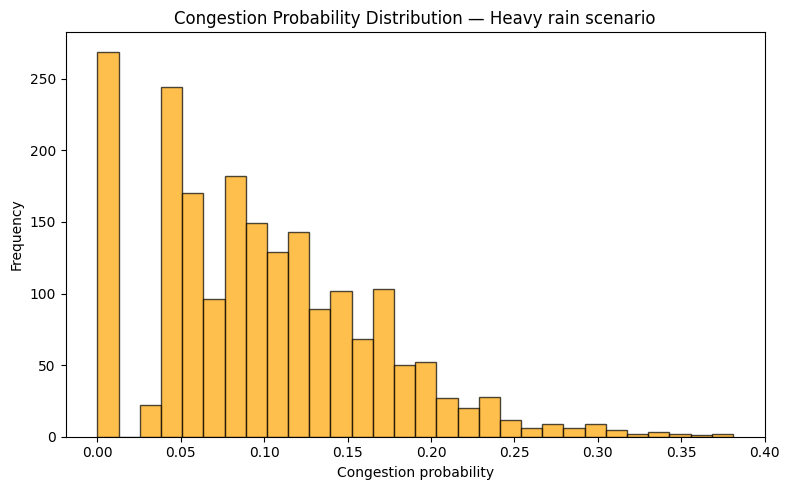

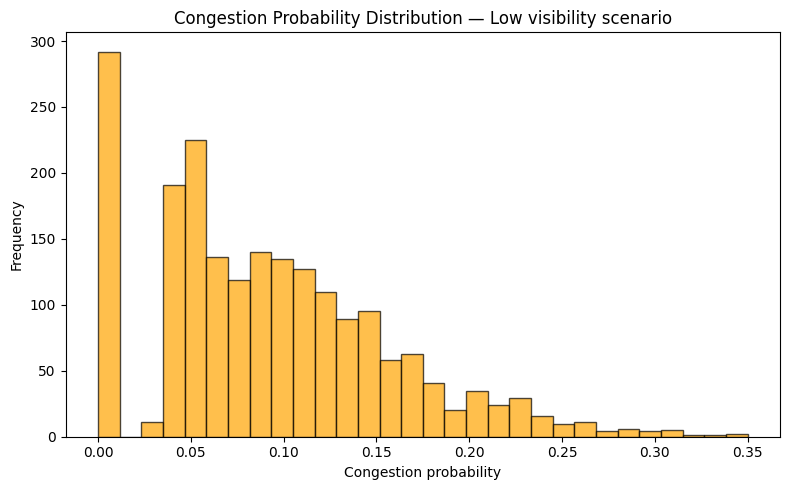

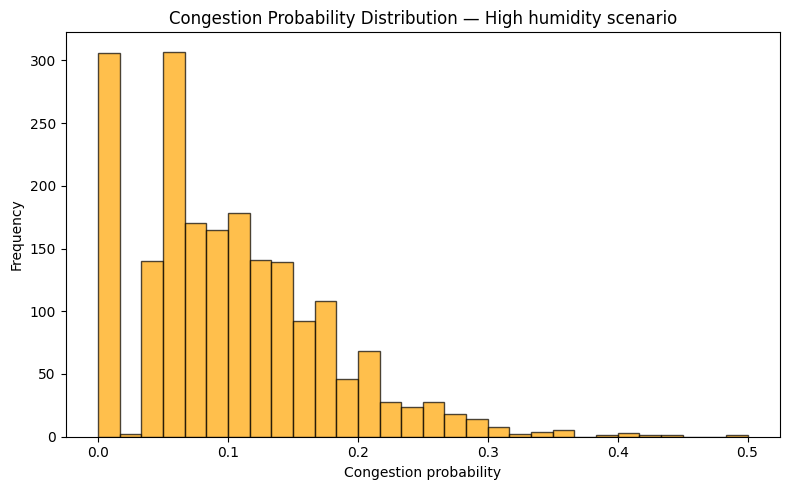

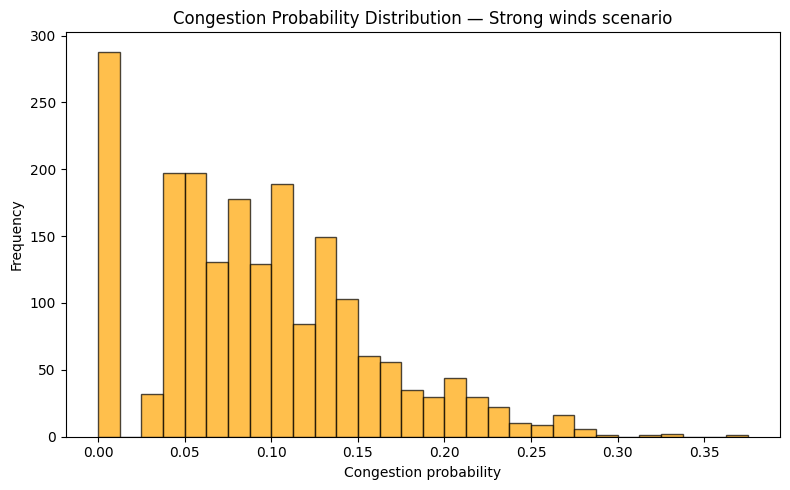

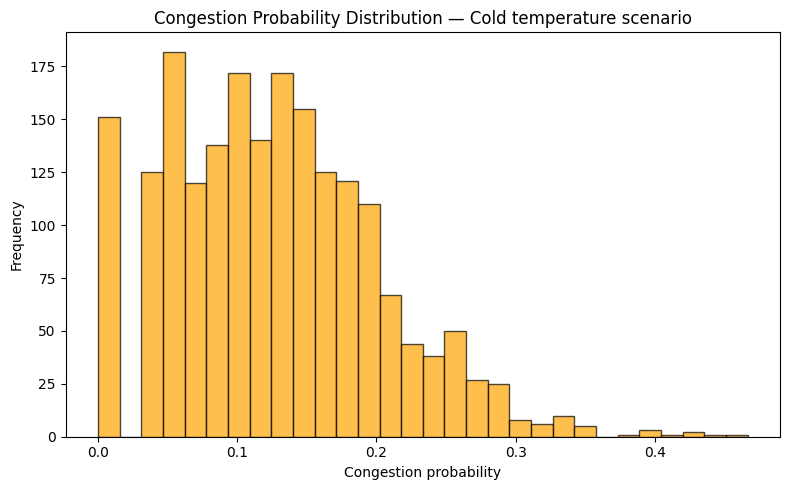

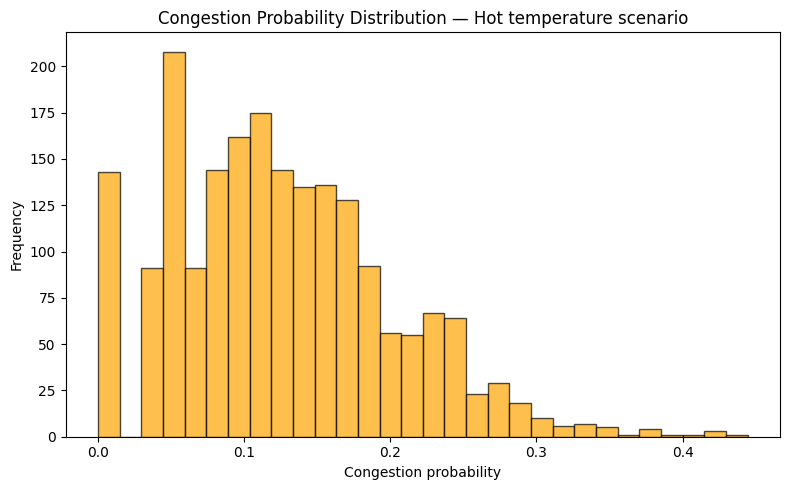

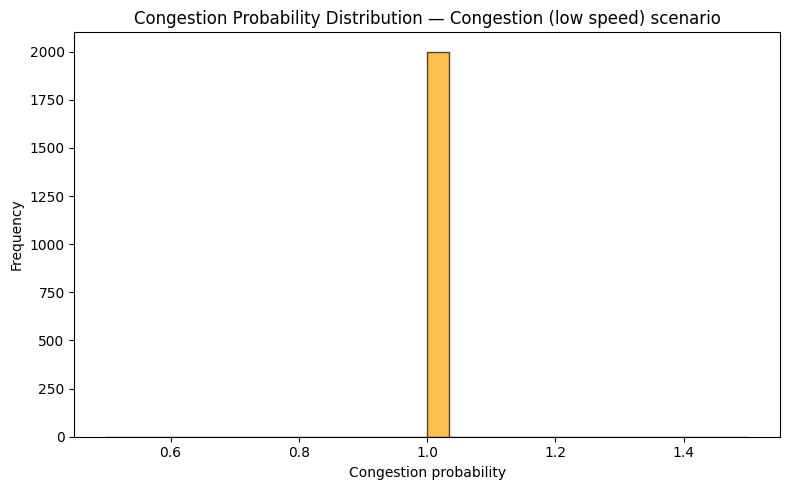

In [18]:
# Loop through each scenario and plot only congestion probability distributions
for name, func in scenarios.items():
    acc_probs, cong_probs = monte_carlo(df, func, iterations=2000)
    
    if cong_probs.size:  
        plt.figure(figsize=(8,5))
        plt.hist(cong_probs, bins=30, alpha=0.7, color="orange", edgecolor="black")
        plt.title(f"Congestion Probability Distribution — {name} scenario")
        plt.xlabel("Congestion probability")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
